In [ ]:
#INSTALL TDT
!pip install tdt
# LOAD DATA AND LIBRARIES
import tdt
from tdt import read_block, epoc_filter
import matplotlib.pyplot as plt #python libraries to read and visualize data
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
import csv
from scipy.stats import sem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#MOUNT GOOGLE DRIVE
#if your datasets are not stored in gdrive, skip this
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#LOAD PHOTOMETRY AND BEHAVIOR DATA
mouse = '001v' #change this
experiment = 'Pre'#change this
date = '20230504'#change this
PATH = 'gdrive/MyDrive/HabonJackie/GRAB2.0/' + mouse + '/'
sensorType='GRABda'
photometry = read_block(PATH + mouse + experiment + date)

read from t=0s to t=508.42s


In [ ]:
#CREATE VARIABLES FROM PHOTOMETRY DATA
#Specify gcamp and time by sampling rate
num_gcamp_samples = len(photometry.streams.Dv1S.data)
gcamp_time = np.linspace(1, num_gcamp_samples, num_gcamp_samples) / photometry.streams.Dv1S.fs
gcamp = photometry.streams.Dv1S.data
#Specify isosbestic and time by sampling rate
num_iso_samples = len(photometry.streams.Dv2S.data)
iso_time = np.linspace(1, num_iso_samples, num_iso_samples) / photometry.streams.Dv2S.fs
iso = photometry.streams.Dv2S.data
#check that they line up
time = []
if iso_time.all() == gcamp_time.all():
    for i in range(0,len(iso_time)):
        time.append(iso_time[i])
else:
    print("TIMES NOT EQUAL")

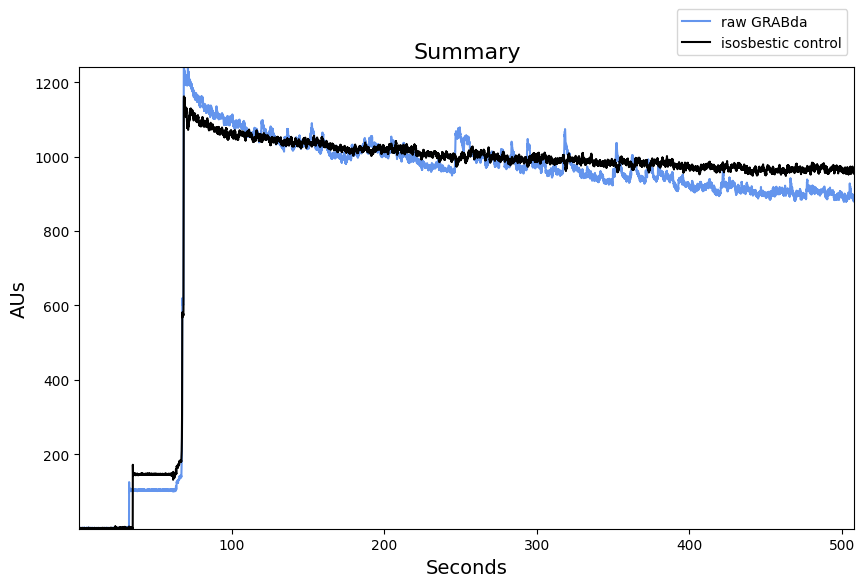

In [ ]:
# PLOT SUMMARY OF PHOTOMETRY DATA

# declare the figure size
fig1 = plt.subplots(figsize=(10, 6))


# plot the line using slices
plt.plot(time,photometry.streams.Dv1S.data, color='cornflowerblue')
plt.plot(time,photometry.streams.Dv2S.data, color = 'k')

# create title, axis labels, and legend
plt.title('Summary', fontsize=16)
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('AUs', fontsize=14)
plt.legend(('raw '+sensorType,'isosbestic control'),
           loc='lower right', 
           bbox_to_anchor=(1.0,1.01)
          )
plt.autoscale(tight=True)

#plt.vlines(x=times[1]/sampling_rate, ymin = -50, ymax = 300, lw=2, color='k', ls ='--')

In [ ]:
#FIND TIMESTAMP TO SYNCHRONIZE YOUR PHOTOMETRY DATA TO BEHAVIOR DATA
sampling_rate = 1017 #this is given, but should be checked sometimes
#next two lines should flank the point of time of your synchronizing event (TTL or not)
startTime = 0
endTime = 50
syncTime = []
for i in range(startTime*sampling_rate,endTime*sampling_rate):
    if photometry.streams.Dv1S.data[i] >= (photometry.streams.Dv1S.data[i-(int(sampling_rate))] + 100):
      syncTime = i/sampling_rate
      break

In [ ]:
# CREATE VARIABLES FROM BEHAVIOR DATA
behavior_filename = PATH + mouse + experiment + date + '.csv' #DIY: path to behavior file
infile = open(behavior_filename, 'r') 

lines = infile.readlines() 

behavior = []
#for line in lines[1:]: #skip the first line, which is the header
#for i in range(0,len(lines)):
for line in lines[1:]:
     sline = line.strip() #get rid of trailing newline characters at the end of the line
     sline = sline.split(',')  # separates line into a list of items.  ',' tells it to split the lines at the commas
        #colonyCount = int(sline[1]) #store the colony count for the line as an integer
     temp = sline[0:5]
     behavior.append(temp)
#close the file
infile.close()

#behavior #to see file

In [ ]:
convertTimes = []
for i in range(0,len(behavior)):
  convertTimes.append(datetime.strptime(behavior[i][1],"%H:%M:%S"))

secondsIn = []
for i in range(1,len(behavior)):
  secondsIn.append((convertTimes[i]-convertTimes[0]).seconds)

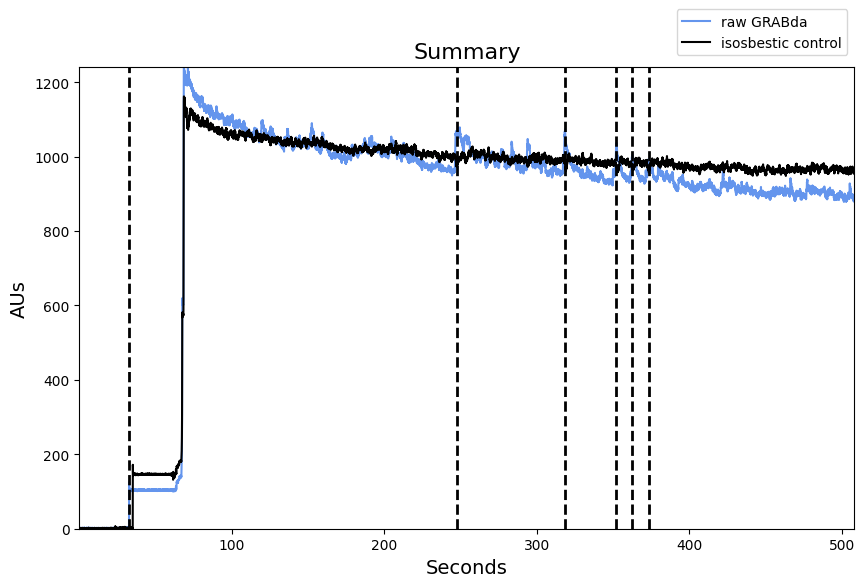

In [ ]:
# PLOT SUMMARY OF PHOTOMETRY DATA WITH SYNCHRONIZER TIMM AND THINGS OF ITNEREST

# declare the figure size
fig1 = plt.subplots(figsize=(10, 6))


# plot the line using slices
plt.plot(time,photometry.streams.Dv1S.data, color='cornflowerblue')
plt.plot(time,photometry.streams.Dv2S.data, color = 'k')

# create title, axis labels, and legend
plt.title('Summary', fontsize=16)
plt.xlabel('Seconds', fontsize=14)
plt.ylabel('AUs', fontsize=14)
plt.legend(('raw '+sensorType,'isosbestic control'),
           loc='lower right', 
           bbox_to_anchor=(1.0,1.01)
          )
plt.autoscale(tight=True)

plt.vlines(x=syncTime, ymin = 0, ymax = max(photometry.streams.Dv1S.data), lw=2, color='k', ls ='--')

for i in range(0,len(secondsIn)):
    #if behaviorTable[i][3] == eventType:
  plt.vlines(x=secondsIn[i] +syncTime, ymin = 0, ymax = max(photometry.streams.Dv1S.data), lw=2, color='k', ls ='--')


In [ ]:
# LINEAR REGRESSION 
X = gcamp.reshape(-1, 1)
Y = iso.reshape(-1,1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X,Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
signal = X - Y_pred
#Credit: https://towardsdatascience.com/linear-regression-in-6-lines-of-python-5e1d0cd05b8d

IndexError: ignored

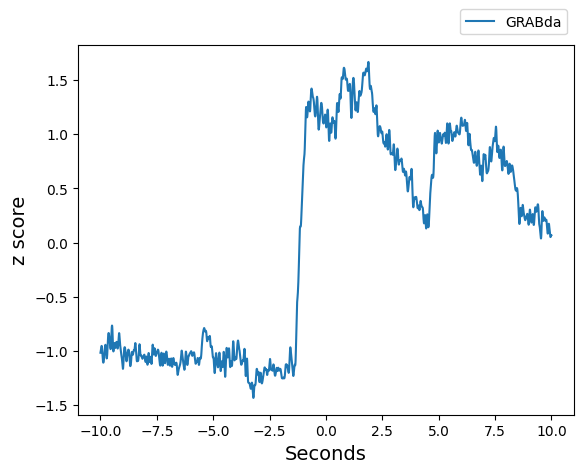

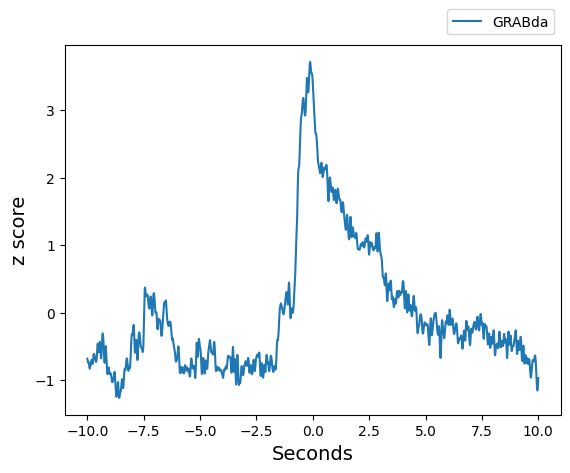

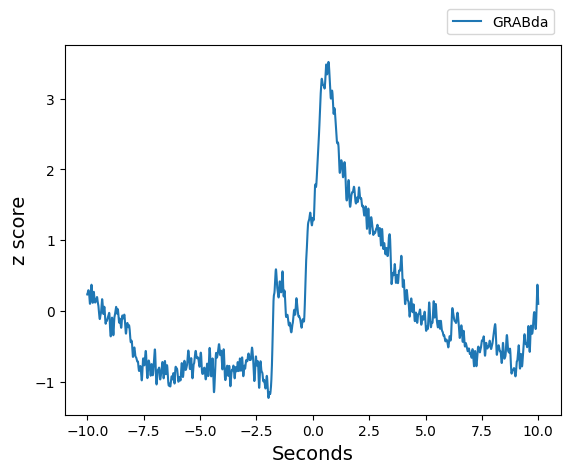

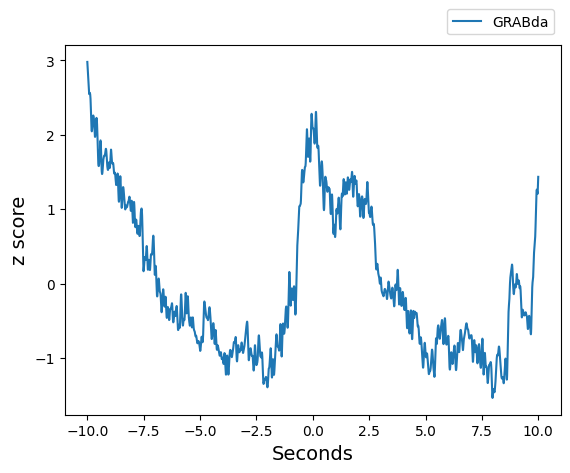

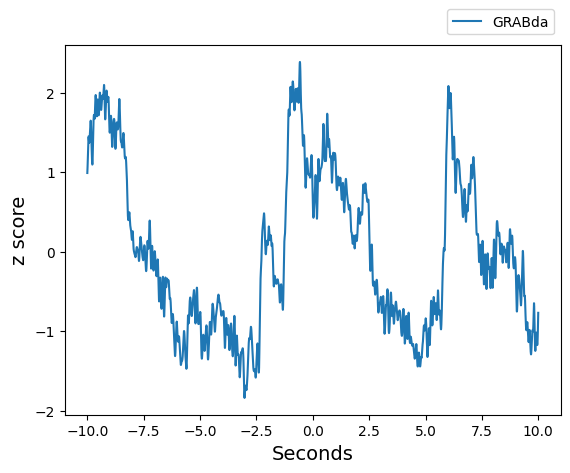

In [ ]:
# NOW PLOT INDIVIDUAL EVENTS AND GENERATE AN OUTPUT FILE FOR THEM
from scipy import stats
outputFile = []
time = np.array(time)
offset = 10 #seconds
for i in range(0, len(behavior)):
    indices = np.argwhere(((np.array(time)>=(secondsIn[i]+syncTime)-offset))&(np.array(time)<((secondsIn[i]+syncTime)+offset)))[0:]
    windowT = time[int(indices[0]):int(indices[-1])]
    windowS = signal[int(indices[0]):int(indices[-1])]
    zscore = stats.zscore(windowS)
    outputFile.append(zscore)
    plt.figure()
    plt.plot(np.linspace(-offset,offset,len(windowS)),zscore) #can do windowT to double check
    # create title, axis labels, and legend
    #plt.title((eventType,i+1), fontsize=16)
    plt.xlabel('Seconds', fontsize=14)
    plt.ylabel('z score', fontsize=14)
    plt.legend((sensorType,),
           loc='lower right', 
           bbox_to_anchor=(1.0,1.01)
          )
outputFile.insert(0, np.array((np.linspace(-offset,offset,len(windowS)))))

In [ ]:
# CREATE OUTPUT FILE 
smoothingFactor = 2000 #OPTIONAL DIY: extent of rolling average

transposed_list = list(zip(*outputFile))
transposed_list = pd.DataFrame(transposed_list, columns=['Individual', 'VidEvents','Type','Trial','Notes?'])

rollingAvg = []
rollingAvg.append(transposed_list.iloc[0])

for i in range (1, len(outputFile)):
    add = transposed_list.iloc[i].rolling(smoothingFactor,min_periods=1).mean()
    rollingAvg.append(add)
    
with open(PATH + mouse+experiment+date+"."+str(smoothingFactor)+'X.Output.csv', 'a') as f:
    writer = csv.writer(f)
    for i in range(0,len(rollingAvg)):
        writer.writerow(rollingAvg[i])
#outputFile2 #to see all trials

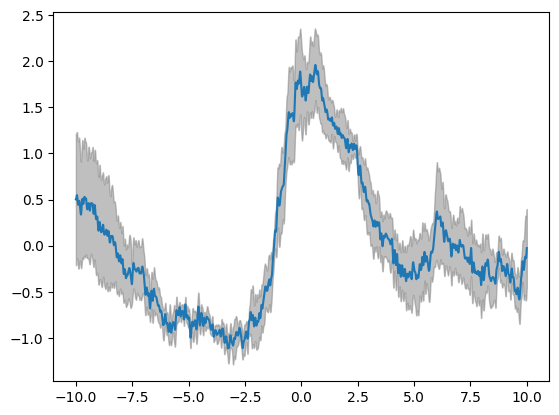

In [ ]:
fT = np.arange(-10,10,(offset*2/len(windowS))) #time made for plot
plt.plot(fT,np.mean(transposed_list,1))
ysem = transposed_list.sem(axis=1)
ymean = transposed_list.mean(axis=1)
plt.fill_between(fT,ymean-ysem,ymean+ysem,color='grey',alpha=0.5,label='sem')